# FIDS Custom FL

This notebook creates a federated intrusion detection system (FIDS) using a custom class which implemented in our GitHub module. The aggregator and clients are created in the same runtime and clients are trained sequentially.

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download project repository
!git clone https://github.com/brendon-felix/VehicleCybersecFL.git &> /dev/null
!cp ./VehicleCybersecFL/anomalydetection/* .

In [ ]:
# %%writefile FederatedLearning.py
from functions import *
from FederatedAggregator import *
from FederatedClient import *
class FederatedLearning:
    '''Class used for simulating federated learning on one or multiple runtimes
    '''
    def __init__(self, params, dataframe=None, verbose=False):
        '''
        Args:
            params (dict): dictionary of parameters used for federated learning models
            dataframe (pd.DataFrame): DataFrame used for train, val and test
            verbose (bool): verbose output
        '''
        self.params = params
        self.verbose = verbose
        self.val_loss_list = [float('inf')]
        self.iteration = 0
        self.aggregator = FederatedAggregator(params, verbose=verbose)
        self.aggregator.initialize_model()
        if dataframe is not None:
            self.ds_dict, self.df_dict = get_train_val_test(dataframe, params, verbose=verbose)
        else:
            self.ds_dict = None
            self.df_dict = None
        self.client_loss = []
        self.clients = None
        return

    def initialize_clients(self, data_split=None):
        '''Initialize a set of locally created clients which run on the same runtime as the aggregator
        '''
        if self.df_dict is None:
            print("No training data given! Please set object parameter 'dataframe'")
            return
        train_df = self.df_dict['train']
        num_clients = self.params['num_clients']
        if data_split is not None:
            if num_clients != len(data_split):
                print('Initialization error: Length of data split does not match number of clients!')
                return
        else:
            data_split = [1/num_clients for _ in range(num_clients)]
        self.clients = []
        if self.verbose:
            print('Initializing clients and generating models...')
        start = 0
        for i in range(num_clients):
            num_samples = int(len(train_df) * data_split[i])
            end = start + num_samples
            df = train_df.iloc[start:end]
            if self.verbose:
                print(f'Client {i}:')
            new_client = FederatedClient(
                df,
                self.params,
                client_id=i,
                verbose=self.verbose)
            new_client.initialize_model()
            self.clients.append(new_client)
            if self.verbose:
                print()
            start = end
            self.client_loss.append([])
        return
    
    def validate_global_model(self):
        '''Use validation set to validate global model before being sent to the clients
        '''
        if self.ds_dict is None:
            print("No validation data given! Please set object parameter 'dataframe'")
            return
        print('\rValidating global model...', end='')
        if self.verbose:
            print()
        verbose = 'auto' if self.verbose else 0
        loss, metric = self.aggregator.global_model.evaluate(self.ds_dict['val'], verbose=verbose)
        if self.verbose:
            print(f"Validation loss: {loss:.5}\nValidation {self.params['metric']}: {metric:.5}")
        self.val_loss_list.append(loss)
        return

    def iterate(self, validate=True):
        '''Execute one iteration (round) of federated learning
        Args:
            validate (bool): perform validation at the end of the iteration (round)
        '''
        if self.clients is not None:
            for j, client in enumerate(self.clients):
                print(f"\rIteration {self.iteration+1}/{self.params['num_iterations']} - Client {j+1}/{len(self.clients)}", end='')
                if self.verbose:
                    print()
                loss = client.iterate()
                self.client_loss[j].append(loss)
        else:
            print(f"\rIteration {self.iteration+1}/{self.params['num_iterations']}", end='')
        if self.verbose:
            print()
        self.aggregator.iterate()

        if validate:
            min_loss = np.min(self.val_loss_list)
            self.validate_global_model()
            if self.val_loss_list[-1] > min_loss:
                return True
        if self.clients is not None:
            for client in self.clients:
                client.load_global_model()
        self.iteration += 1
        return False

    def test_global_model(self):
        '''Use test set to test global model loss after all iterations are completed
        '''
        if self.ds_dict is None:
            print("No testing data given! Please set object parameter 'dataframe'")
            return
        print('\rTesting global model...')
        verbose = 'auto' if self.verbose else 0
        loss, metric = self.aggregator.global_model.evaluate(self.ds_dict['test'], verbose=verbose)
        print(f"Test loss: {loss:.5}\nTest {self.params['metric']}: {metric:.5}")
        return
    
    def run_server(self, validation=False, test=False):
        '''Run a sever which aggregates client models and distributes global model
        Args:
            validation (bool): perform validation at the end of each iteration (round)
            test (bool): perform testing after all iterations have completed
        '''
        if self.verbose:
            print('Starting Server...')
        self.aggregator.initialize_model()
        num_iterations = self.params['num_iterations']
        for i in range(num_iterations):
            if self.iterate(validation):    # early stop if validation loss increases
                break
        save_path = self.params['model_dir']+'global_model_final.h5'
        tf.keras.models.save_model(self.aggregator.global_model, save_path)
        if test:
            self.test_global_model()
        return
    
    def run_federated_learning(self, data_split=None, validation=False, test=False):
        '''Start a federated learning simulation
        Args:
            data_split (tuple): relative proportions of data given to each client (must add to 1.0)
            validation (bool): perform validation at the end of each iteration (round)
            test (bool): perform testing after all iterations have completed
        '''
        self.initialize_clients(data_split=data_split)
        self.run_server(validation, test)
        return


Overwriting FederatedLearning.py


In [ ]:
# %%writefile FederatedClient.py
from functions import *
class FederatedClient:
    '''Class for an individual client used in federated learning
    '''
    client_id = 0
    def __init__(self, dataframe, params, client_id=None, verbose=False):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame which contains SynCAN data for training
            params (dict): dictionary containing parameters used for federated learning models
            client_id (int): used to manually specify a unqiue client_id
            verbose (bool): verbose output
        '''
        self.dataset, self.dataframe = create_dataset(dataframe, params, verbose=verbose)
        self.params = params
        if client_id is not None:
            self.client_id = client_id
        else:
            self.client_id = FederatedClient.client_id
            FederatedClient.client_id += 1
        self.verbose = verbose
        self.iteration = 1
        return
    
    def initialize_model(self):
        '''Initialize an INDRA-like model using the given params
        '''
        self.model = create_model(self.params)
        self.load_global_model()
        compile_model(self.model, self.params)
        return
    
    def load_global_model(self):
        '''Load global model from model_dir and set client model weights
        '''
        file_path = self.params['model_dir']+'global_model_'+str(self.iteration-1)+'.h5'
        interval = 2
        while not os.path.exists(file_path):
            if self.verbose:
                print(f'\rWaiting for global model {self.iteration-1}...', end='')
            time.sleep(interval)
        global_model = tf.keras.models.load_model(file_path)
        self.model.set_weights(global_model.get_weights())
        return
    
    def train_model(self):
        '''Train the client model for one iteration of federated learning
        '''
        if self.verbose:
            print('Training model...')
        callbacks_list = [
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=self.params['patience']),
            ]
        verbose = 'auto' if self.verbose else 0
        history = self.model.fit(self.dataset,
            epochs=self.params['epochs_per_round'],
            use_multiprocessing=True,
            workers=6,
            shuffle=True,
            callbacks=callbacks_list,
            verbose=verbose)
        loss = history.history['loss']
        # loss = 0
        return loss
    
    def iterate(self):
        '''Execute one iteration (round) of federated learning
        '''
        loss = self.train_model()
        save_path = self.params['model_dir']+'client'+str(self.client_id)+'_model_'+str(self.iteration)+'.h5'
        tf.keras.models.save_model(self.model, save_path)
        self.iteration += 1
        return loss

    def run_client(self):
        '''Run remote client over num_iterations (only needed for remote use, not local)
        '''
        if self.verbose:
            print(f'Starting Client {self.client_id}...')
        self.initialize_model()
        num_iterations = self.params['num_iterations']
        for i in range(num_iterations):
            print(f'\rIteration {self.iteration}/{num_iterations}', end='')
            if self.verbose:
                print()
            self.iterate()
            if self.verbose:
                print(f'Loading global model {self.iteration-1}...')
            self.load_global_model()
        return


Overwriting FederatedClient.py


In [ ]:
# import custom modules
%run functions
%run id_labels
%run FederatedLearning

<Figure size 640x480 with 0 Axes>

In [ ]:
download_SynCAN(num_train_files=4)

Finished


In [ ]:
from psutil import virtual_memory
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(f'GPU: {gpu_info[599:619]}')
ram_gb = virtual_memory().total / 1e9
print(f'RAM: {ram_gb:.1f} GB')

GPU: Tesla T4            
RAM: 13.6 GB


In [ ]:
id = 5      # message ID must be between 1 and 10
signal_counts = [2, 3, 2, 1, 2, 2, 2, 1, 1, 4]
num_signals = signal_counts[id-1]

def set_params(id, num_clients, folder):
    params = {
        'msg_id': 'id'+str(id),
        'train_split': 0.8,
        'val_split': 0.1,
        'warm_up': 10,
        'time_steps': 50,
        'seq_stride': 5,
        'batch_size': 128,
        'drop_out': True,
        'input_dim': num_signals,
        'latent_dim': 16*num_signals,
        'loss_function': 'mse',
        'learning_rate': 0.0001,
        'metric': 'mae',
        'attention': False,
        'epochs_per_round': 1,
        'patience': 1,
        'num_clients': num_clients,
        'num_iterations': 5,
        'model_dir': '/content/drive/MyDrive/Senior Design 22-23/Models/FIDSVarDist/id'+str(id)+'/'+folder,
    }
    return params
params = set_params(id, 1, 'test/')

# Prepare Data


In [ ]:
train_df = import_data('SynCAN/train.csv', params['msg_id'])
# train_df = train_df.iloc[:len(train_df)//2]
# train_df

29,669,725 total messages (id1,id2,...,id10)
4,139,820 messages used (id5)
0 anomalous messages out of 4,139,820



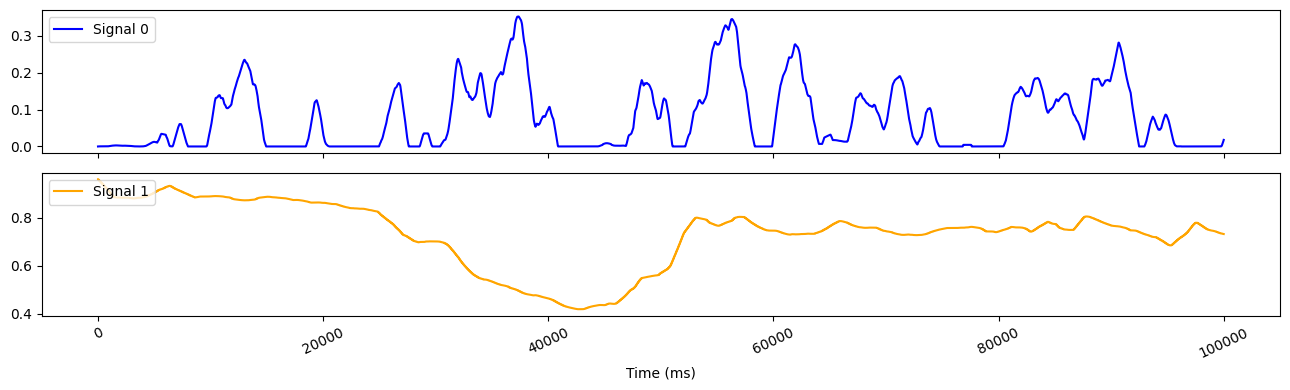

In [ ]:
visualize_data(train_df, end_time=1e5)

# Train and Aggregate

In [ ]:
# !rm -r /content/models

In [ ]:
np.logspace(-0.5, 1, num=5)

array([ 0.31622777,  0.74989421,  1.77827941,  4.21696503, 10.        ])

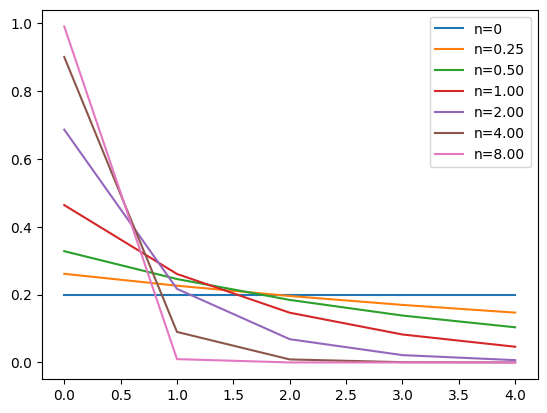

In [ ]:
dists = [np.array(5*[0.2])]
plt.plot(dists[0], label='n=0')
for n in np.logspace(-2, 3, base=2, num=6):
    dist = np.logspace(0, -n, num=5)
    dist = dist/(dist.sum())
    dists.append(dist)
    plt.plot(dist, label=f'n={n:.2f}')
plt.legend()
plt.show()

In [ ]:
dists

[array([0.2, 0.2, 0.2, 0.2, 0.2]),
 array([0.26126158, 0.22624321, 0.19591855, 0.16965847, 0.14691818]),
 array([0.32785167, 0.24585407, 0.18436455, 0.1382539 , 0.1036758 ]),
 array([0.46373649, 0.26077819, 0.14664636, 0.08246531, 0.04637365]),
 array([0.68594137, 0.21691371, 0.06859414, 0.02169137, 0.00685941]),
 array([9.00009e-01, 9.00009e-02, 9.00009e-03, 9.00009e-04, 9.00009e-05]),
 array([9.9e-01, 9.9e-03, 9.9e-05, 9.9e-07, 9.9e-09])]

In [ ]:
num_clients = 5

for n, split in zip([0, 0.25, 0.5, 1, 2, 4, 8], dists):
    print(f'Using n = {n}...')
    params = set_params(id, num_clients, 'n'+str(n)+'/')
    fl = FederatedLearning(params, train_df, verbose=True)
    fl.run_federated_learning(validation=False, data_split=split, test=False)

Using n = 0...
Using model directory /content/drive/MyDrive/Senior Design 22-23/Models/FIDSVarDist/id5/n0/
Initializing global model...
Train:
662,360 subsequences of length 50
5,175 batches (batch size 128)

Val:
82,785 subsequences of length 50
647 batches (batch size 128)

Test:
82,785 subsequences of length 50
647 batches (batch size 128)

Initializing clients and generating models...
Client 0:
132,462 subsequences of length 50
1,035 batches (batch size 128)

Client 1:
132,462 subsequences of length 50
1,035 batches (batch size 128)

Client 2:
132,462 subsequences of length 50
1,035 batches (batch size 128)

Client 3:
132,462 subsequences of length 50
1,035 batches (batch size 128)

Client 4:
132,462 subsequences of length 50
1,035 batches (batch size 128)

Starting Server...
Initializing global model...
Iteration 1/5 - Client 1/5
Training model...
1035/1035 [==============================] - 31s 25ms/step - loss: 0.0268 - mae: 0.1161
Iteration 1/5 - Client 2/5
Training model...
10

IndexError: ignored